In [24]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# list of stock tickers to download
# tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']
# tickers = ['^NSEBANK','']
# tickers = ['^NSEI']
tickers =

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()



ERROR:yfinance:Could not get exchangeTimezoneName for ticker '' reason: 'chart'
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['']: %ticker%Y%ticker%F%ticker%T%ticker%z%ticker%M%ticker%i%ticker%s%ticker%s%ticker%i%ticker%n%ticker%g%ticker%E%ticker%r%ticker%r%ticker%o%ticker%r%ticker%(%ticker%'%ticker%$%ticker%:%ticker% %ticker%p%ticker%o%ticker%s%ticker%s%ticker%i%ticker%b%ticker%l%ticker%y%ticker% %ticker%d%ticker%e%ticker%l%ticker%i%ticker%s%ticker%t%ticker%e%ticker%d%ticker%;%ticker% %ticker%N%ticker%o%ticker% %ticker%t%ticker%i%ticker%m%ticker%e%ticker%z%ticker%o%ticker%n%ticker%e%ticker% %ticker%f%ticker%o%ticker%u%ticker%n%ticker%d%ticker%'%ticker%)%ticker%


In [25]:
print(stock_data.tail())

Attribute       Date    Ticker     Adj Close         Close          High  \
236       2024-07-11  ^NSEBANK  52270.648438  52270.648438  52400.300781   
237       2024-07-12  ^NSEBANK  52278.898438  52278.898438  52794.550781   
238       2024-07-15  ^NSEBANK  52455.898438  52455.898438  52662.250000   
239       2024-07-16  ^NSEBANK  52396.800781  52396.800781  52619.050781   
240       2024-07-18  ^NSEBANK  52620.699219  52620.699219  52782.750000   

Attribute           Low          Open    Volume  
236        51749.449219  52316.898438  138300.0  
237        52171.148438  52272.648438  171000.0  
238        52154.000000  52330.050781  186100.0  
239        52331.601562  52466.699219  158800.0  
240        52168.648438  52215.050781  139400.0  


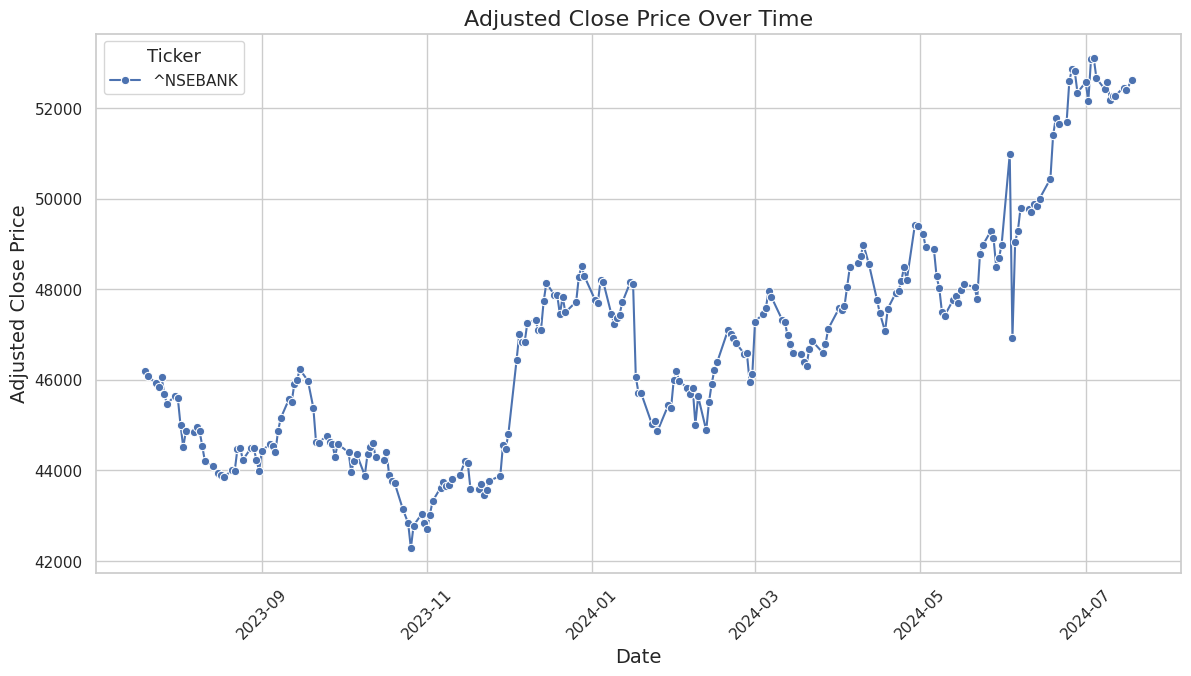

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

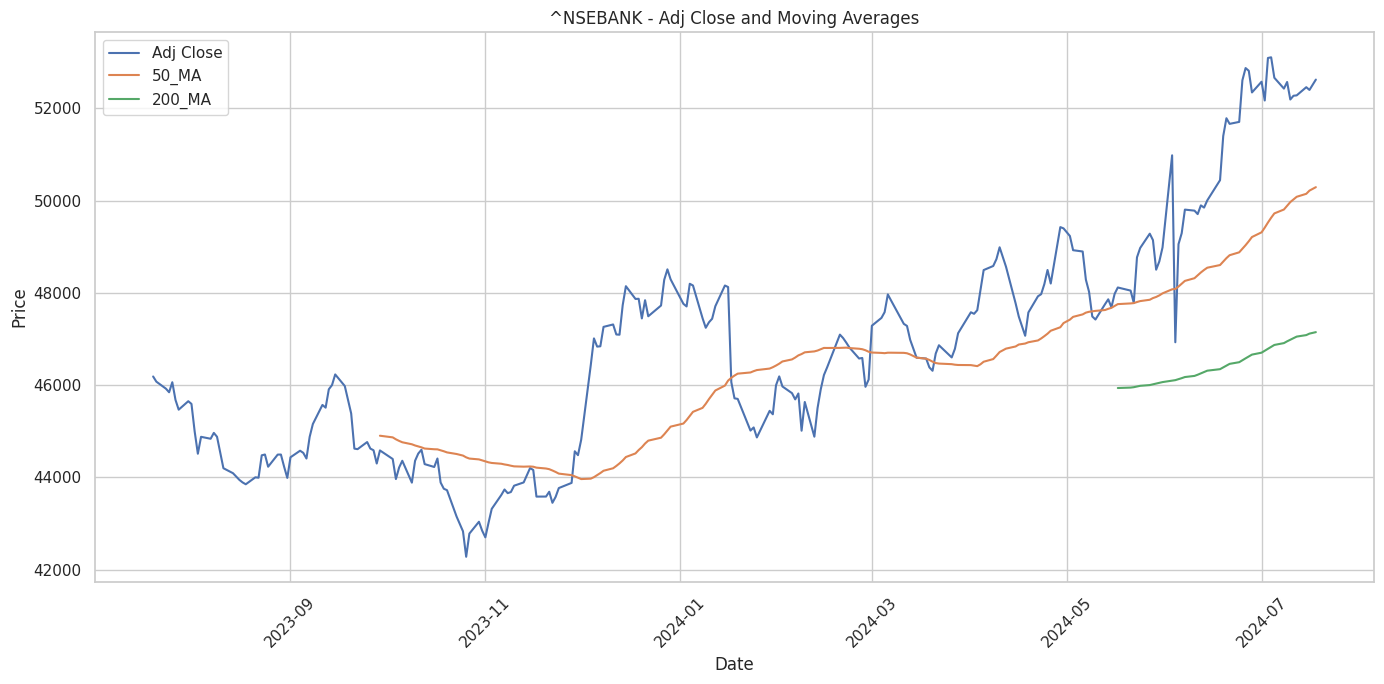

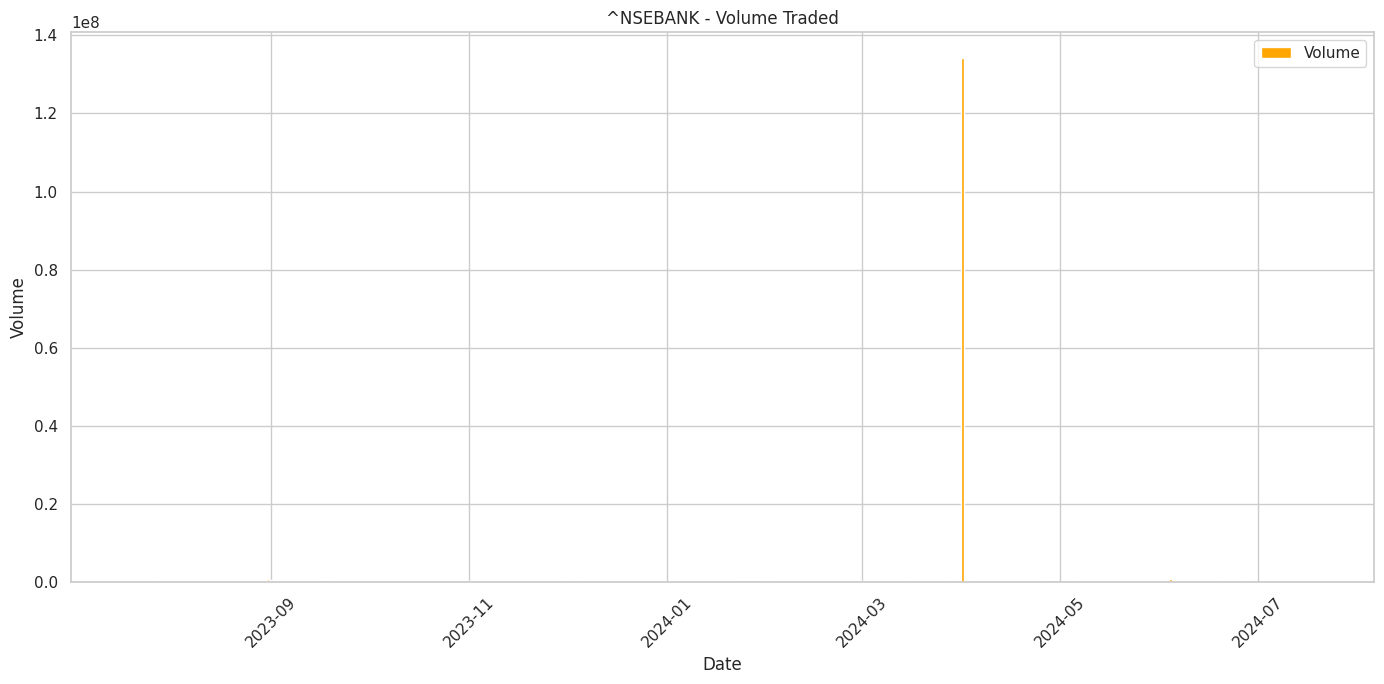

In [34]:
short_window = 50
long_window = 200

# stock_data.set_index('Date',inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
  ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
  ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window =short_window).mean()
  ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window =long_window).mean()

  plt.figure(figsize =( 14,7))
  plt.plot(ticker_data.index , ticker_data['Adj Close'] , label ='Adj Close')
  plt.plot(ticker_data.index , ticker_data['50_MA'] , label ='50_MA')
  plt.plot(ticker_data.index , ticker_data['200_MA'] , label ='200_MA')
  plt.title(f'{ticker} - Adj Close and Moving Averages')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(14, 7))
  plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
  plt.title(f'{ticker} - Volume Traded')
  plt.xlabel('Date')
  plt.ylabel('Volume')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()



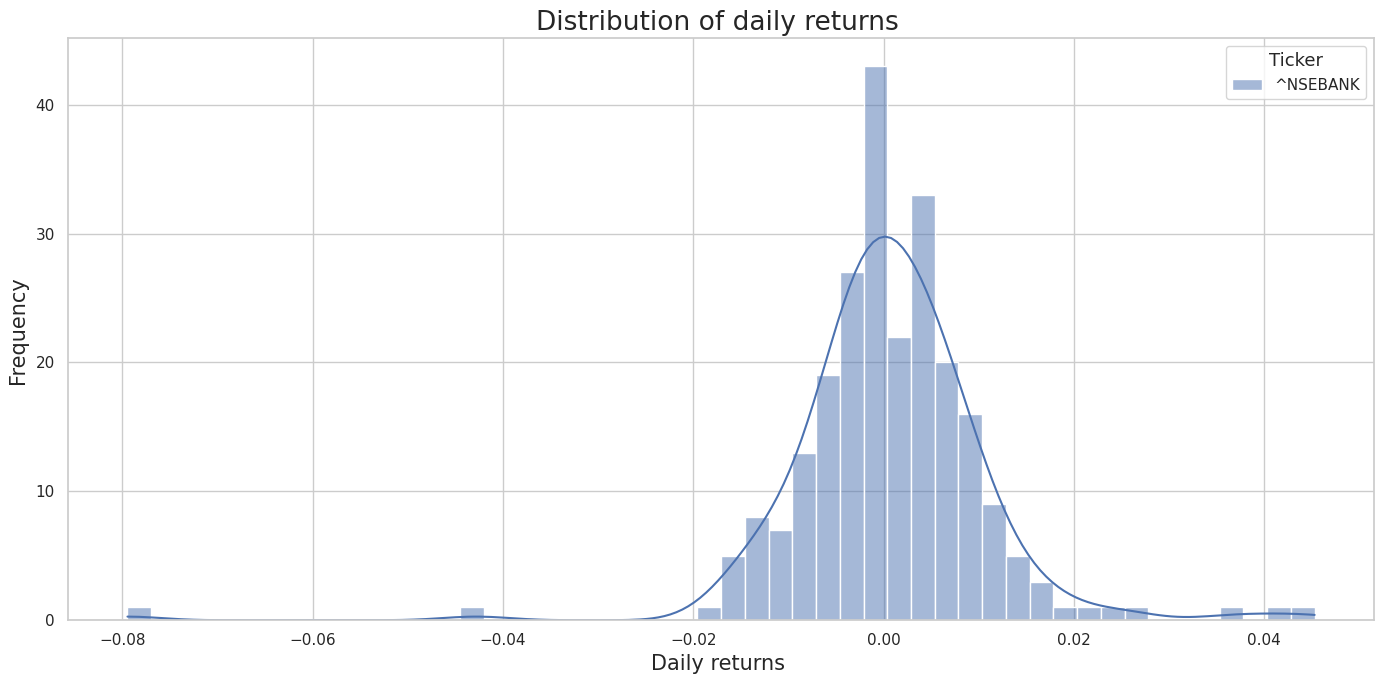

In [39]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14,7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
  ticker_data = stock_data[stock_data['Ticker'] == ticker]
  sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of daily returns ',fontsize = 19)
plt.xlabel('Daily returns ',fontsize = 15)
plt.ylabel('Frequency ',fontsize=15)
plt.legend(title = 'Ticker' , title_fontsize = '13' )
plt.grid(True)
plt.tight_layout()
plt.show()


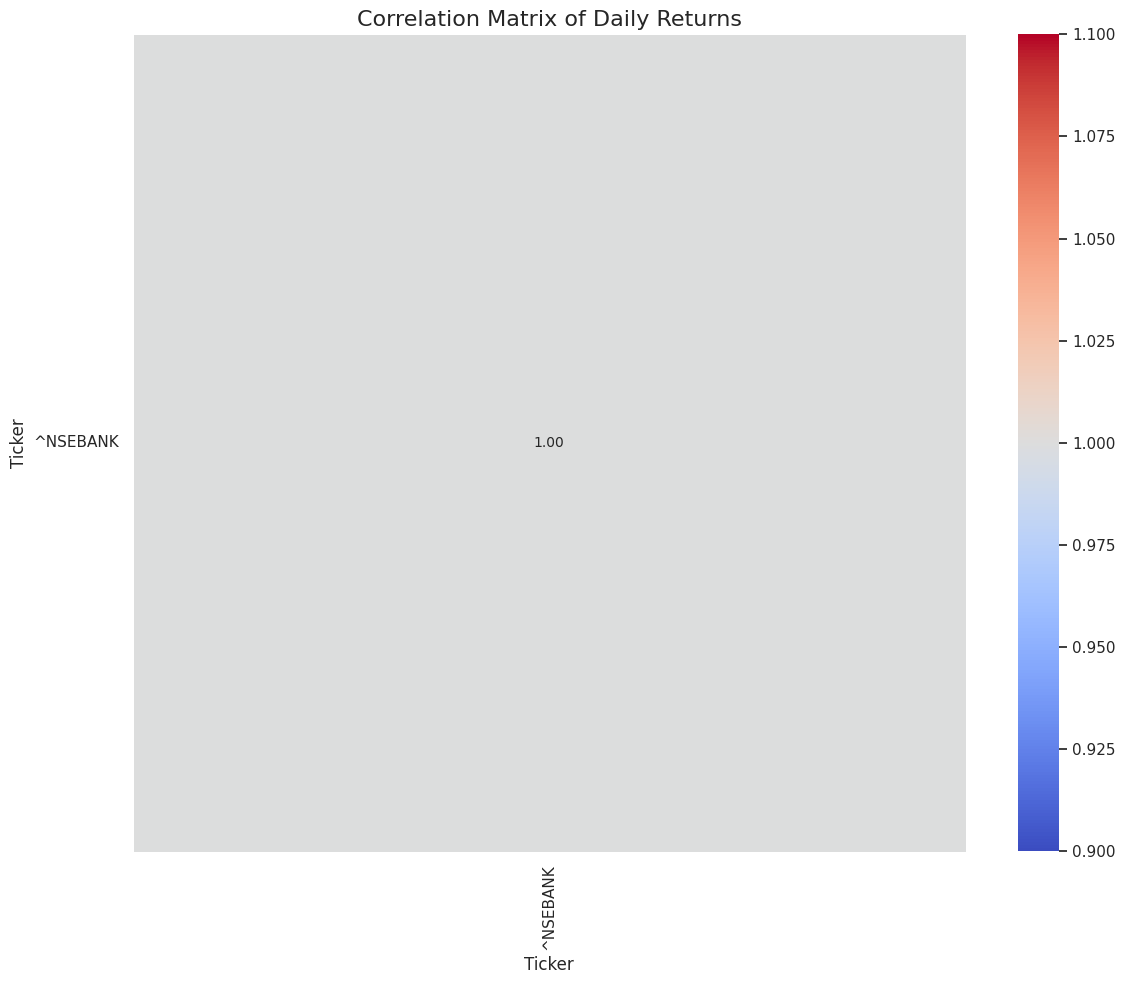

In [45]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [41]:
import numpy as np

daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')

expected_returns  = daily_returns.mean() * 252
volatility = daily_returns.std() *np.sqrt(252)

stock_stats = pd.DataFrame({
    'Expected Return' : expected_returns,
    'Volatility' : volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
^NSEBANK,0.151046,0.167309


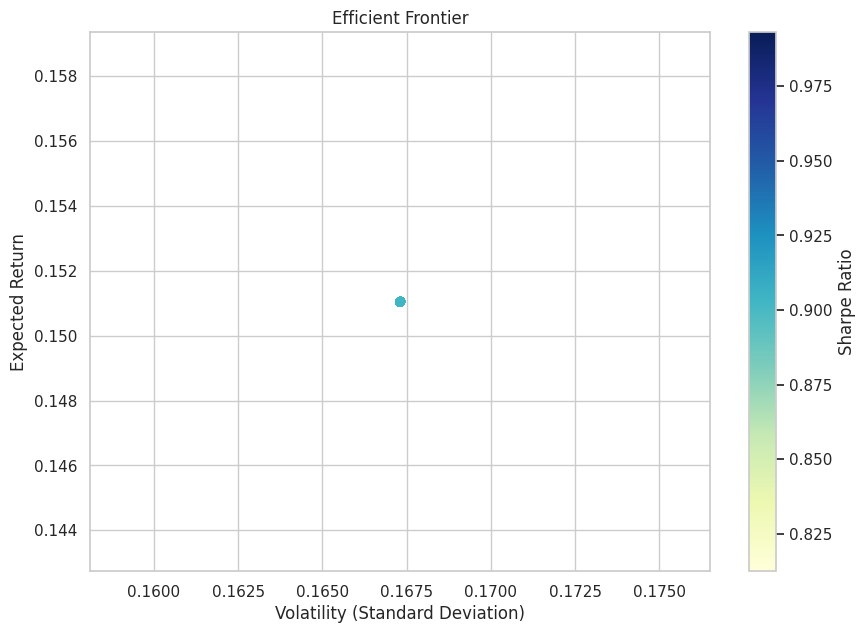

In [42]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [43]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.1510463107796224, 0.1673090169708378, 0.9027983877638226)

EXPECTED RETURN 15%
VOLATILITY 16%
SHARPEN RATION 90%


In [44]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,^NSEBANK,1.0
